# IMBD Sentimental Analysis Review

El siguiente proyecto tiene como objetivo la aplicación de técnicas de NLP para realizar un análisis de sentimientos sobre un dataset formado por reviews de diferentes películas de la base de datos IMBD. Todas ellas vienen correctamente tagueadas con su correspondiente sentimiento, positivo o negativo.

## 0. Librerias

Importamos los paquetes que necesitaremos para poder trabajar:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras import layers

## 1. Carga de datos

Cargamos los datos con los que trabajaremos que será un csv formado por las reviews y su tag en cuanto al sentimiento.

In [ ]:
reviews = pd.read_csv("IMBD_data.csv")

In [ ]:
reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


A su vez cargaremos los datos de las stop words:

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alvarorodriguezgonzalez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopwords = set(stopwords.words('english'))

In [ ]:
print(stopwords)

{'has', 'herself', 'over', 'very', 'my', 'a', 'doesn', "aren't", 'so', "haven't", 'yourselves', 'at', 'should', 'are', 'wasn', 'this', 'both', 'been', 'will', "shan't", 'me', "you'll", 'our', 'yourself', "she's", 'when', 'she', 'you', 'we', 'where', 'him', 'because', 'here', 'but', 'which', 'your', 'ourselves', 'he', 'o', "shouldn't", 'shan', 'an', 'into', "wouldn't", 'until', 'the', 'don', 'own', 'what', 'now', 're', 'shouldn', 'myself', 'that', 'himself', 'no', 'do', 'theirs', 'whom', 'being', 'above', 'nor', 'their', 'through', 'few', 'weren', "mustn't", 'yours', 'these', 'mightn', 'then', 'while', 'did', 'and', 'why', 'doing', "don't", 'll', 'aren', "you'd", "hasn't", 'after', 'them', 'again', 'those', 'am', 'hasn', 'her', 'each', 'further', 'too', 'needn', 'just', 'how', "didn't", 'to', 'same', 's', 't', 'hers', 'it', 'his', 'for', 'there', 'they', 'on', 'does', "it's", 'haven', 'not', 've', 'any', 'only', 'didn', 'up', 'couldn', "won't", 'between', 'most', 'if', 'ma', 'i', 'mustn

## 2. Análisis Exploratorio

Veamos si nuestros datos estan balanceados:

<AxesSubplot:xlabel='sentiment', ylabel='count'>

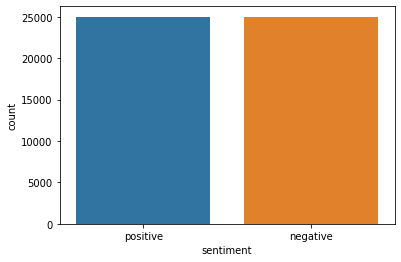

In [ ]:
sns.countplot(x = "sentiment", data = reviews)

# Análisis de palabras




In [ ]:
from nltk.tokenize import word_tokenize

def get_word_tokens(sentences):
    '''Word tokenization'''
    words = []
    for sent in sentences:
        words.extend(word_tokenize(sent))
    print(words)
    return(words)

In [ ]:
review_words = get_word_tokens(review_post)

In [ ]:
import matplotlib
from nltk.probability import FreqDist
matplotlib.use('TkAgg')

def plot_freq_dist(words, num_words = 20):
    fdist = FreqDist(words)
    fdist.plot(num_words,cumulative=False)

In [ ]:
# plot_freq_dist(sample_words, num_words=10)
plot_freq_dist(review_words, num_words=20)

In [ ]:
nltk.download('averaged_perceptron_tagger')

def get_pos_tags(words):
    tags=[]
    for word in words:
        tags.append(nltk.pos_tag([word]))
    print(tags)
    return tags

In [ ]:
sample_tags = get_pos_tags(review_words)

In [ ]:
tag_fd = nltk.FreqDist(l[0][1] for l in sample_tags)
tag_fd.most_common()

Aquí explicaremos qué es cada tag de los más repetidos:


1.   NN: Noun
2.   NNS: Noun plural
3.   JJ: This NLTK POS Tag is an adjective
4.   RB: Adverb
5.   VGB: Verb gerund
6.   VBN: Verb past participle
7.   VB Verb
8.   IN: Preposition/subordinating conjunction
9.   CD: Cardinal digit
10.  Verb past tense 


In [ ]:
import wordcloud
import matplotlib.pyplot as plt

In [ ]:
wc2 = wordcloud.WordCloud(
    width=1000, 
    height=1000, 
    stopwords=stopwords,
    max_words=100,
    collocations=False
).generate(text=(' '.join(review_words)).lower())

In [ ]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.figure(figsize=[10,10])
plt.imshow(wc2)
plt.axis("off")

## 3. Preprocesado

Como se puede ver en el caso que se encuentra abajo, podemos encontrarnos con tags de código html:

In [ ]:
reviews.iloc[1,0]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

Para ello crearemos una función que te permita eliminar todos los tags del código:

In [ ]:
def tags_out(review,stopwords):
    review = review.lower()
    review = re.sub('<br />','',review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)
    for palabra in stopwords:
        review = re.sub(' ' + palabra + ' ',' ', review)
    review = re.sub(r'\s+',' ', review)
    return review

In [ ]:
tags_out(reviews.iloc[1,0],stopwords)

'a wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done '

Una vez visto que nuestra función trabaja correctamente vamos a aplicarselo a todas las reviews:

In [ ]:
review_post = []
reviews_list = list(reviews['review'])
for review in reviews_list:
    review_post.append(tags_out(review,stopwords))

Por último pasaremos de string a integer la columna sentimientos:

In [ ]:
sentimiento = reviews['sentiment']
sentimiento = np.array(list(map(lambda x: 1 if x=="positive" else 0, sentimiento)))

## 4. División de datos

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(review_post, sentimiento,test_size=0.20, random_state=2022)

## 5. Proceso de Tokenización

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 150 
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

A continuación lo que haremos será crear un diccionario de embedding el cual nos resultará muy útil para los pesos de las diferentes redes:

In [ ]:
def embeddings(path):
    embeddings_dictionary = dict()
    embeddings_file=open(path)
    for line in embeddings_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:],dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
    embeddings_file.close()
    embedding_matrix = np.zeros((vocab_size, 150))
    
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    
    return embedding_matrix

## 6. Modelos

Una cosa que será bastante importante es la evaluación del modelo. Para ello definiremos una función que permita sacar los resultados.

In [ ]:
def evaluateModel(model):
    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])

### 6.1. Simple Neural Network

In [ ]:
model = keras.Sequential(
      [
          layers.Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen , trainable=False),
          layers.Flatten(),
          layers.Dense(1,activation="sigmoid"),
      ]
  )

NameError: name 'embedding_matrix' is not defined

## 7. Comparaciones

## 8. Lineas de Investigación